 # Training an optimized GRU model optimized with recall

In [10]:
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!p "/content/drive/My Drive/"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content
/bin/bash: line 1: p: command not found


In [11]:
!pip install optuna


In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Sun May 25 10:22:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             41W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
import joblib, numpy as np, torch, optuna, gc
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay,
)
from pathlib import Path


DRIVE_PROJECT = "/content/drive/My Drive/Project 3/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

SUPER = joblib.load(DRIVE_PROJECT + "optimized_data_processing/super_data_payload.pkl")
train_df = SUPER["train_df"]
val_df = SUPER["val_df"]
FEATURE_SETS = SUPER["feature_sets"]
ALL_NUMERIC_COLS = SUPER["numeric_cols"]

CKPT_DIR = Path(DRIVE_PROJECT + "gru_ckpts_recall")
CKPT_DIR.mkdir(exist_ok=True)


# Helper: build sliding windows
def build_windows(df, win_len, stride, feature_cols):
    data, labels = [], []
    for _, fl in df.groupby("flight_id"):
        X = fl[feature_cols].to_numpy(dtype=np.float32)
        y = fl["is_7700"].to_numpy(dtype=np.int8)  # chdanged from bool to int
        for i in range(0, len(X) - win_len + 1, stride):
            data.append(X[i : i + win_len])
            labels.append(int(y[i : i + win_len].any()))  # 1 if ANY emergency in window
    return np.stack(data), np.array(labels)


# GRU module (same as before) ---------------------------------------
class GRUClassifier(nn.Module):
    def __init__(self, n_feats, hidden, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_feats,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden, 1))

    def forward(self, x):
        # x : (B, T, F)
        _, h_n = self.gru(x)  # h_n : (num_layers, B, hidden)
        logits = self.head(h_n[-1])  # use last layer’s hidden
        return logits


def run_epoch(model, loader, train, optim=None):
    model.train(train)
    total, preds, gts = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logit = model(xb)
        loss = nn.functional.binary_cross_entropy_with_logits(logit, yb)
        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()
        total += loss.item() * yb.size(0)
        preds.extend((torch.sigmoid(logit) > 0.5).cpu().numpy().ravel())
        gts.extend(yb.cpu().numpy().ravel())
    return total / len(loader.dataset), recall_score(gts, preds)

Running on cuda


In [13]:
# print(f"Training set size: {len(train_df)}")
# flights = train_df.flight_id.unique()
# print(len(flights), "flights in training set")
# print(len(val_df.flight_id.unique()), "flights in validation set")

# selected_flights = np.random.choice(
#     flights, size=int(len(flights) * 0.1), replace=False
# )
# print("Using", len(selected_flights), "flights for training")

# train_df = train_df[train_df.flight_id.isin(selected_flights)]
# print("Training set size:", len(train_df))

  ## 1.  Optuna objective with per-epoch logging

In [14]:
window_cache = {}


def get_windows(df, feat_key, win_len, stride):
    # Different DataFrames have different id() values
    cache_key = f"{id(df)}_{feat_key}_{win_len}_{stride}"
    if cache_key not in window_cache:
        if feat_key == "all_numeric":
            X_np, y_np = build_windows(df, win_len, stride, ALL_NUMERIC_COLS)
        else:
            X_np, y_np = build_windows(df, win_len, stride, FEATURE_SETS[feat_key])
        X_t = torch.tensor(X_np, dtype=torch.float32)
        y_t = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
        window_cache[cache_key] = (X_t, y_t)
    return window_cache[cache_key]

In [15]:
def objective(trial: optuna.trial.Trial):
    print(f"---- Trial #{trial.number}  --  started ----------------------------")
    try:
        # -- data hyper-params
        feat_key = trial.suggest_categorical(
            "features", ["all_numeric", "baseline", "gru_delta"]
        )

        win_len = trial.suggest_categorical("win_len", [30, 60, 120])
        stride = trial.suggest_categorical("stride", [10, 20])

        X_tr, y_tr = get_windows(train_df, feat_key, win_len, stride)
        X_va, y_va = get_windows(val_df, feat_key, win_len, stride)

        BATCH = 256
        tr_loader = DataLoader(
            TensorDataset(X_tr, y_tr),
            batch_size=BATCH,
            shuffle=True,
            drop_last=True,
        )
        va_loader = DataLoader(
            TensorDataset(X_va, y_va),
            batch_size=BATCH,
            shuffle=False,
        )

        # -- model hyper-params

        hidden = trial.suggest_categorical("hidden", [64, 128, 256])
        layers = trial.suggest_int("layers", 1, 3)
        drop = trial.suggest_float("drop", 0.0, 0.4, step=0.1)

        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

        print(
            f"Using features: {feat_key}, win_len: {win_len}, stride: {stride}, "
            f"hidden: {hidden}, layers: {layers}, drop: {drop}, lr: {lr}"
        )

        model = GRUClassifier(X_tr.shape[2], hidden, layers, drop).to(DEVICE)

        optim = torch.optim.Adam(model.parameters(), lr=lr)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim, mode="max", factor=0.5, patience=1
        )

        # -- training loop with logging

        lr_curve, tr_loss_curve, val_recall_curve = [], [], []

        EPOCHS = 10

        for ep in range(1, EPOCHS + 1):
            print(f"Epoch {ep}/{EPOCHS}  —  LR: {optim.param_groups[0]['lr']:.6f}")

            tr_loss, _ = run_epoch(model, tr_loader, True, optim)
            _, val_recall = run_epoch(model, va_loader, False)
            lr_now = optim.param_groups[0]["lr"]
            lr_curve.append(float(lr_now))
            tr_loss_curve.append(float(tr_loss))
            val_recall_curve.append(float(val_recall))

            # report for pruning & Optuna dashboards
            trial.report(val_recall, ep)
            if trial.should_prune():
                print(f"Trial pruned at epoch {ep}, recall: {val_recall}")
                raise optuna.TrialPruned()
            scheduler.step(val_recall)
        ckpt_path = CKPT_DIR / f"trial_{trial.number}.pt"
        torch.save(model.state_dict(), ckpt_path)

        # save curves for later plotting
        trial.set_user_attr("lr_curve", lr_curve)
        trial.set_user_attr("train_loss_curve", tr_loss_curve)
        trial.set_user_attr("val_recall_curve", val_recall_curve)
        trial.set_user_attr("ckpt", str(ckpt_path))
        trial.set_user_attr("features", feat_key)
        trial.set_user_attr("win_len", win_len)
        trial.set_user_attr("stride", stride)

        # tidy memory
        del model, X_tr, y_tr, X_va, y_va, tr_loader, va_loader
        torch.cuda.empty_cache()
        gc.collect()

        return val_recall_curve[-1]  # final validation recall
    except Exception as e:
        print(f"Trial #{trial.number} failed with error: {e}")
        raise

  ## 2.  Launch / resume the study

In [16]:
import optuna

TRIALS = 72

optuna.logging.set_verbosity(optuna.logging.DEBUG)


# DB = "sqlite:///gru_hpo.db"
DB = f"sqlite:///{DRIVE_PROJECT}/gru_hpo_recall.db"

study = optuna.create_study(
    study_name="gru_hpo_recall",
    direction="maximize",
    storage=DB,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
)


study.optimize(objective, n_trials=TRIALS)


print("Best recall:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-25 10:22:04,014] A new study created in RDB with name: gru_hpo_recall


---- Trial #0  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 20, hidden: 256, layers: 3, drop: 0.2, lr: 0.00022201639415028723
Epoch 1/10  —  LR: 0.000222
Epoch 2/10  —  LR: 0.000222
Epoch 3/10  —  LR: 0.000222
Epoch 4/10  —  LR: 0.000222
Epoch 5/10  —  LR: 0.000222
Epoch 6/10  —  LR: 0.000222
Epoch 7/10  —  LR: 0.000222
Epoch 8/10  —  LR: 0.000111
Epoch 9/10  —  LR: 0.000111
Epoch 10/10  —  LR: 0.000056


[I 2025-05-25 10:23:10,317] Trial 0 finished with value: 0.4452699356116889 and parameters: {'features': 'gru_delta', 'win_len': 30, 'stride': 20, 'hidden': 256, 'layers': 3, 'drop': 0.2, 'lr': 0.00022201639415028723}. Best is trial 0 with value: 0.4452699356116889.


---- Trial #1  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden: 64, layers: 1, drop: 0.0, lr: 0.00028575285639154916
Epoch 1/10  —  LR: 0.000286
Epoch 2/10  —  LR: 0.000286
Epoch 3/10  —  LR: 0.000286
Epoch 4/10  —  LR: 0.000286
Epoch 5/10  —  LR: 0.000286
Epoch 6/10  —  LR: 0.000286
Epoch 7/10  —  LR: 0.000286
Epoch 8/10  —  LR: 0.000143
Epoch 9/10  —  LR: 0.000143
Epoch 10/10  —  LR: 0.000071


[I 2025-05-25 10:23:46,929] Trial 1 finished with value: 0.4816521309856837 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 1, 'drop': 0.0, 'lr': 0.00028575285639154916}. Best is trial 1 with value: 0.4816521309856837.


---- Trial #2  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 20, hidden: 256, layers: 3, drop: 0.2, lr: 0.0006517874081121625
Epoch 1/10  —  LR: 0.000652
Epoch 2/10  —  LR: 0.000652
Epoch 3/10  —  LR: 0.000652
Epoch 4/10  —  LR: 0.000652
Epoch 5/10  —  LR: 0.000326
Epoch 6/10  —  LR: 0.000326
Epoch 7/10  —  LR: 0.000326
Epoch 8/10  —  LR: 0.000326
Epoch 9/10  —  LR: 0.000326
Epoch 10/10  —  LR: 0.000163


[I 2025-05-25 10:24:43,493] Trial 2 finished with value: 0.5118045236915965 and parameters: {'features': 'gru_delta', 'win_len': 30, 'stride': 20, 'hidden': 256, 'layers': 3, 'drop': 0.2, 'lr': 0.0006517874081121625}. Best is trial 2 with value: 0.5118045236915965.


---- Trial #3  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden: 128, layers: 2, drop: 0.30000000000000004, lr: 0.00013498658954868745
Epoch 1/10  —  LR: 0.000135
Epoch 2/10  —  LR: 0.000135
Epoch 3/10  —  LR: 0.000135
Epoch 4/10  —  LR: 0.000135
Epoch 5/10  —  LR: 0.000135
Epoch 6/10  —  LR: 0.000135
Epoch 7/10  —  LR: 0.000135
Epoch 8/10  —  LR: 0.000067
Epoch 9/10  —  LR: 0.000067
Epoch 10/10  —  LR: 0.000067


[I 2025-05-25 10:25:21,489] Trial 3 finished with value: 0.49646207010037846 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 20, 'hidden': 128, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.00013498658954868745}. Best is trial 2 with value: 0.5118045236915965.


---- Trial #4  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 20, hidden: 128, layers: 1, drop: 0.0, lr: 0.0005335499128243722
Epoch 1/10  —  LR: 0.000534
Epoch 2/10  —  LR: 0.000534
Epoch 3/10  —  LR: 0.000534
Epoch 4/10  —  LR: 0.000534
Epoch 5/10  —  LR: 0.000267
Epoch 6/10  —  LR: 0.000267
Epoch 7/10  —  LR: 0.000267
Epoch 8/10  —  LR: 0.000267
Epoch 9/10  —  LR: 0.000267
Epoch 10/10  —  LR: 0.000267


[I 2025-05-25 10:25:58,149] Trial 4 finished with value: 0.5201579726838901 and parameters: {'features': 'gru_delta', 'win_len': 60, 'stride': 20, 'hidden': 128, 'layers': 1, 'drop': 0.0, 'lr': 0.0005335499128243722}. Best is trial 4 with value: 0.5201579726838901.


---- Trial #5  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 10, hidden: 256, layers: 3, drop: 0.4, lr: 0.0008663493483905527
Epoch 1/10  —  LR: 0.000866
Epoch 2/10  —  LR: 0.000866
Epoch 3/10  —  LR: 0.000866
Epoch 4/10  —  LR: 0.000866
Epoch 5/10  —  LR: 0.000866
Epoch 6/10  —  LR: 0.000433
Epoch 7/10  —  LR: 0.000433
Epoch 8/10  —  LR: 0.000217
Epoch 9/10  —  LR: 0.000217
Epoch 10/10  —  LR: 0.000108


[I 2025-05-25 10:28:46,077] Trial 5 finished with value: 0.5183508887425938 and parameters: {'features': 'gru_delta', 'win_len': 60, 'stride': 10, 'hidden': 256, 'layers': 3, 'drop': 0.4, 'lr': 0.0008663493483905527}. Best is trial 4 with value: 0.5201579726838901.


---- Trial #6  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 10, hidden: 256, layers: 1, drop: 0.2, lr: 0.0026914885397741587
Epoch 1/10  —  LR: 0.002691
Epoch 2/10  —  LR: 0.002691
Epoch 3/10  —  LR: 0.002691
Epoch 4/10  —  LR: 0.002691
Epoch 5/10  —  LR: 0.002691
Epoch 6/10  —  LR: 0.002691
Epoch 7/10  —  LR: 0.001346
Epoch 8/10  —  LR: 0.001346
Epoch 9/10  —  LR: 0.000673
Epoch 10/10  —  LR: 0.000673


[I 2025-05-25 10:30:05,548] Trial 6 finished with value: 0.5045037600198331 and parameters: {'features': 'gru_delta', 'win_len': 30, 'stride': 10, 'hidden': 256, 'layers': 1, 'drop': 0.2, 'lr': 0.0026914885397741587}. Best is trial 4 with value: 0.5201579726838901.


---- Trial #7  --  started ----------------------------
Using features: baseline, win_len: 30, stride: 10, hidden: 256, layers: 2, drop: 0.4, lr: 0.0009724303348412737
Epoch 1/10  —  LR: 0.000972
Epoch 2/10  —  LR: 0.000972
Epoch 3/10  —  LR: 0.000972
Epoch 4/10  —  LR: 0.000972
Epoch 5/10  —  LR: 0.000972
Epoch 6/10  —  LR: 0.000486
Epoch 7/10  —  LR: 0.000486
Epoch 8/10  —  LR: 0.000243
Epoch 9/10  —  LR: 0.000243
Epoch 10/10  —  LR: 0.000122


[I 2025-05-25 10:31:43,552] Trial 7 finished with value: 0.6132551028840592 and parameters: {'features': 'baseline', 'win_len': 30, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.4, 'lr': 0.0009724303348412737}. Best is trial 7 with value: 0.6132551028840592.


---- Trial #8  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 10, hidden: 64, layers: 2, drop: 0.0, lr: 0.0007108907559878005
Epoch 1/10  —  LR: 0.000711
Epoch 2/10  —  LR: 0.000711
Epoch 3/10  —  LR: 0.000711


[I 2025-05-25 10:32:05,493] Trial 8 pruned. 


Trial pruned at epoch 3, recall: 0.4710335747202107
Trial #8 failed with error: 
---- Trial #9  --  started ----------------------------
Using features: baseline, win_len: 30, stride: 20, hidden: 64, layers: 2, drop: 0.2, lr: 0.0003850945144607265
Epoch 1/10  —  LR: 0.000385
Epoch 2/10  —  LR: 0.000385
Epoch 3/10  —  LR: 0.000385
Epoch 4/10  —  LR: 0.000385
Epoch 5/10  —  LR: 0.000385
Epoch 6/10  —  LR: 0.000385
Epoch 7/10  —  LR: 0.000193
Epoch 8/10  —  LR: 0.000193
Epoch 9/10  —  LR: 0.000193
Epoch 10/10  —  LR: 0.000096


[I 2025-05-25 10:32:42,826] Trial 9 finished with value: 0.5730559683011391 and parameters: {'features': 'baseline', 'win_len': 30, 'stride': 20, 'hidden': 64, 'layers': 2, 'drop': 0.2, 'lr': 0.0003850945144607265}. Best is trial 7 with value: 0.6132551028840592.


---- Trial #10  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.4, lr: 0.001919163875208349
Epoch 1/10  —  LR: 0.001919
Epoch 2/10  —  LR: 0.001919
Epoch 3/10  —  LR: 0.001919
Epoch 4/10  —  LR: 0.000960
Epoch 5/10  —  LR: 0.000960
Epoch 6/10  —  LR: 0.000480
Epoch 7/10  —  LR: 0.000480
Epoch 8/10  —  LR: 0.000240
Epoch 9/10  —  LR: 0.000240
Epoch 10/10  —  LR: 0.000120


[I 2025-05-25 10:36:01,756] Trial 10 finished with value: 0.5999510244061709 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.4, 'lr': 0.001919163875208349}. Best is trial 7 with value: 0.6132551028840592.


---- Trial #11  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.4, lr: 0.0020552725139293512
Epoch 1/10  —  LR: 0.002055
Epoch 2/10  —  LR: 0.002055
Epoch 3/10  —  LR: 0.002055
Epoch 4/10  —  LR: 0.002055
Epoch 5/10  —  LR: 0.002055
Epoch 6/10  —  LR: 0.001028
Epoch 7/10  —  LR: 0.001028
Epoch 8/10  —  LR: 0.000514
Epoch 9/10  —  LR: 0.000514
Epoch 10/10  —  LR: 0.000257


[I 2025-05-25 10:39:15,938] Trial 11 finished with value: 0.5774222512447963 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.4, 'lr': 0.0020552725139293512}. Best is trial 7 with value: 0.6132551028840592.


---- Trial #12  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.4, lr: 0.0014661187675270907
Epoch 1/10  —  LR: 0.001466
Epoch 2/10  —  LR: 0.001466
Epoch 3/10  —  LR: 0.001466
Epoch 4/10  —  LR: 0.001466
Epoch 5/10  —  LR: 0.001466
Epoch 6/10  —  LR: 0.001466
Epoch 7/10  —  LR: 0.000733
Epoch 8/10  —  LR: 0.000733
Epoch 9/10  —  LR: 0.000367
Epoch 10/10  —  LR: 0.000367


[I 2025-05-25 10:42:29,551] Trial 12 finished with value: 0.6657415721165619 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.4, 'lr': 0.0014661187675270907}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #13  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.30000000000000004, lr: 0.0014680166186286396
Epoch 1/10  —  LR: 0.001468
Epoch 2/10  —  LR: 0.001468
Epoch 3/10  —  LR: 0.001468
Epoch 4/10  —  LR: 0.001468
Epoch 5/10  —  LR: 0.000734
Epoch 6/10  —  LR: 0.000734
Epoch 7/10  —  LR: 0.000734
Epoch 8/10  —  LR: 0.000734
Epoch 9/10  —  LR: 0.000367
Epoch 10/10  —  LR: 0.000367


[I 2025-05-25 10:45:43,647] Trial 13 finished with value: 0.5800342829156804 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.0014680166186286396}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #14  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.30000000000000004, lr: 0.004557493020091865
Epoch 1/10  —  LR: 0.004557
Epoch 2/10  —  LR: 0.004557
Epoch 3/10  —  LR: 0.004557
Epoch 4/10  —  LR: 0.004557
Epoch 5/10  —  LR: 0.004557
Epoch 6/10  —  LR: 0.002279
Epoch 7/10  —  LR: 0.002279
Epoch 8/10  —  LR: 0.002279
Epoch 9/10  —  LR: 0.001139
Epoch 10/10  —  LR: 0.001139


[I 2025-05-25 10:48:52,315] Trial 14 finished with value: 0.6186433760509347 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.004557493020091865}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #15  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 3, drop: 0.30000000000000004, lr: 0.004857432440005791
Epoch 1/10  —  LR: 0.004857
Epoch 2/10  —  LR: 0.004857
Epoch 3/10  —  LR: 0.004857
Epoch 4/10  —  LR: 0.004857
Epoch 5/10  —  LR: 0.004857
Epoch 6/10  —  LR: 0.004857
Epoch 7/10  —  LR: 0.002429
Epoch 8/10  —  LR: 0.002429
Epoch 9/10  —  LR: 0.002429
Epoch 10/10  —  LR: 0.001214


[I 2025-05-25 10:51:07,870] Trial 15 finished with value: 0.6095828911925557 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.004857432440005791}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #16  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden: 256, layers: 1, drop: 0.30000000000000004, lr: 0.004418244006754505
Epoch 1/10  —  LR: 0.004418
Epoch 2/10  —  LR: 0.004418
Epoch 3/10  —  LR: 0.004418
Epoch 4/10  —  LR: 0.004418
Epoch 5/10  —  LR: 0.004418
Epoch 6/10  —  LR: 0.004418
Epoch 7/10  —  LR: 0.002209
Epoch 8/10  —  LR: 0.002209
Epoch 9/10  —  LR: 0.001105
Epoch 10/10  —  LR: 0.001105


[I 2025-05-25 10:53:10,367] Trial 16 finished with value: 0.4772671618643376 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 1, 'drop': 0.30000000000000004, 'lr': 0.004418244006754505}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #17  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.003446635817427107
Epoch 1/10  —  LR: 0.003447
Epoch 2/10  —  LR: 0.003447
Epoch 3/10  —  LR: 0.003447
Epoch 4/10  —  LR: 0.003447
Epoch 5/10  —  LR: 0.001723
Epoch 6/10  —  LR: 0.001723
Epoch 7/10  —  LR: 0.000862
Epoch 8/10  —  LR: 0.000862
Epoch 9/10  —  LR: 0.000431
Epoch 10/10  —  LR: 0.000431


[I 2025-05-25 10:56:25,348] Trial 17 finished with value: 0.6348053220145294 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.003446635817427107}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #18  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.0027276797163193565
Epoch 1/10  —  LR: 0.002728
Epoch 2/10  —  LR: 0.002728
Epoch 3/10  —  LR: 0.002728
Epoch 4/10  —  LR: 0.002728
Epoch 5/10  —  LR: 0.002728
Epoch 6/10  —  LR: 0.002728
Epoch 7/10  —  LR: 0.001364
Epoch 8/10  —  LR: 0.001364
Epoch 9/10  —  LR: 0.000682
Epoch 10/10  —  LR: 0.000682


[I 2025-05-25 10:57:58,087] Trial 18 finished with value: 0.6401110113460126 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.0027276797163193565}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #19  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.0013088415475859042
Epoch 1/10  —  LR: 0.001309
Epoch 2/10  —  LR: 0.001309
Epoch 3/10  —  LR: 0.001309
Epoch 4/10  —  LR: 0.000654
Epoch 5/10  —  LR: 0.000654
Epoch 6/10  —  LR: 0.000654
Epoch 7/10  —  LR: 0.000327
Epoch 8/10  —  LR: 0.000327
Epoch 9/10  —  LR: 0.000164
Epoch 10/10  —  LR: 0.000164


[I 2025-05-25 10:59:30,862] Trial 19 finished with value: 0.5783201371316627 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.0013088415475859042}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #20  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.0027668703814902854
Epoch 1/10  —  LR: 0.002767
Epoch 2/10  —  LR: 0.002767
Epoch 3/10  —  LR: 0.002767
Epoch 4/10  —  LR: 0.002767
Epoch 5/10  —  LR: 0.001383
Epoch 6/10  —  LR: 0.001383
Epoch 7/10  —  LR: 0.001383
Epoch 8/10  —  LR: 0.001383
Epoch 9/10  —  LR: 0.001383
Epoch 10/10  —  LR: 0.000692


[I 2025-05-25 11:01:03,891] Trial 20 finished with value: 0.6392947514488613 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.0027668703814902854}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #21  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.002379270702171194
Epoch 1/10  —  LR: 0.002379
Epoch 2/10  —  LR: 0.002379
Epoch 3/10  —  LR: 0.002379
Epoch 4/10  —  LR: 0.002379
Epoch 5/10  —  LR: 0.001190
Epoch 6/10  —  LR: 0.001190
Epoch 7/10  —  LR: 0.000595
Epoch 8/10  —  LR: 0.000595
Epoch 9/10  —  LR: 0.000595
Epoch 10/10  —  LR: 0.000595


[I 2025-05-25 11:02:36,636] Trial 21 finished with value: 0.6114602889560036 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.002379270702171194}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #22  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.0014767253740475485
Epoch 1/10  —  LR: 0.001477
Epoch 2/10  —  LR: 0.001477
Epoch 3/10  —  LR: 0.001477
Epoch 4/10  —  LR: 0.001477
Epoch 5/10  —  LR: 0.001477
Epoch 6/10  —  LR: 0.001477
Epoch 7/10  —  LR: 0.001477
Epoch 8/10  —  LR: 0.000738
Epoch 9/10  —  LR: 0.000738
Epoch 10/10  —  LR: 0.000738


[I 2025-05-25 11:04:09,612] Trial 22 finished with value: 0.6347236960248143 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.0014767253740475485}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #23  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.0030199783004998533
Epoch 1/10  —  LR: 0.003020
Epoch 2/10  —  LR: 0.003020
Epoch 3/10  —  LR: 0.003020
Epoch 4/10  —  LR: 0.003020
Epoch 5/10  —  LR: 0.001510
Epoch 6/10  —  LR: 0.001510
Epoch 7/10  —  LR: 0.000755
Epoch 8/10  —  LR: 0.000755
Epoch 9/10  —  LR: 0.000377
Epoch 10/10  —  LR: 0.000377


[I 2025-05-25 11:05:42,730] Trial 23 finished with value: 0.6157864664109053 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.0030199783004998533}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #24  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.001827721683611315
Epoch 1/10  —  LR: 0.001828
Epoch 2/10  —  LR: 0.001828
Epoch 3/10  —  LR: 0.001828
Epoch 4/10  —  LR: 0.001828
Epoch 5/10  —  LR: 0.001828
Epoch 6/10  —  LR: 0.000914
Epoch 7/10  —  LR: 0.000914
Epoch 8/10  —  LR: 0.000457
Epoch 9/10  —  LR: 0.000457
Epoch 10/10  —  LR: 0.000228


[I 2025-05-25 11:07:15,488] Trial 24 finished with value: 0.6355399559219655 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.001827721683611315}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #25  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.0, lr: 0.0010946148651103395
Epoch 1/10  —  LR: 0.001095
Epoch 2/10  —  LR: 0.001095
Epoch 3/10  —  LR: 0.001095
Epoch 4/10  —  LR: 0.001095
Epoch 5/10  —  LR: 0.001095
Epoch 6/10  —  LR: 0.001095
Epoch 7/10  —  LR: 0.001095
Epoch 8/10  —  LR: 0.000547
Epoch 9/10  —  LR: 0.000547
Epoch 10/10  —  LR: 0.000547


[I 2025-05-25 11:08:48,082] Trial 25 finished with value: 0.6261529671047261 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.0, 'lr': 0.0010946148651103395}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #26  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.003389171398324571
Epoch 1/10  —  LR: 0.003389
Epoch 2/10  —  LR: 0.003389
Epoch 3/10  —  LR: 0.003389
Epoch 4/10  —  LR: 0.003389
Epoch 5/10  —  LR: 0.003389
Epoch 6/10  —  LR: 0.001695
Epoch 7/10  —  LR: 0.001695
Epoch 8/10  —  LR: 0.000847
Epoch 9/10  —  LR: 0.000847
Epoch 10/10  —  LR: 0.000424


[I 2025-05-25 11:10:21,615] Trial 26 finished with value: 0.5928495633009551 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.003389171398324571}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #27  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 1, drop: 0.2, lr: 0.0024127083615508717
Epoch 1/10  —  LR: 0.002413
Epoch 2/10  —  LR: 0.002413
Epoch 3/10  —  LR: 0.002413


[I 2025-05-25 11:10:47,602] Trial 27 pruned. 


Trial pruned at epoch 3, recall: 0.5697494082115746
Trial #27 failed with error: 
---- Trial #28  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 2, drop: 0.0, lr: 0.001613198509439605
Epoch 1/10  —  LR: 0.001613
Epoch 2/10  —  LR: 0.001613
Epoch 3/10  —  LR: 0.001613
Epoch 4/10  —  LR: 0.000807
Epoch 5/10  —  LR: 0.000807
Epoch 6/10  —  LR: 0.000807
Epoch 7/10  —  LR: 0.000807
Epoch 8/10  —  LR: 0.000807
Epoch 9/10  —  LR: 0.000403
Epoch 10/10  —  LR: 0.000403


[I 2025-05-25 11:12:33,918] Trial 28 finished with value: 0.5865643620928904 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 128, 'layers': 2, 'drop': 0.0, 'lr': 0.001613198509439605}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #29  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 3, drop: 0.2, lr: 0.0012086326964276515
Epoch 1/10  —  LR: 0.001209
Epoch 2/10  —  LR: 0.001209
Epoch 3/10  —  LR: 0.001209
Epoch 4/10  —  LR: 0.001209
Epoch 5/10  —  LR: 0.001209
Epoch 6/10  —  LR: 0.001209
Epoch 7/10  —  LR: 0.001209
Epoch 8/10  —  LR: 0.000604
Epoch 9/10  —  LR: 0.000604
Epoch 10/10  —  LR: 0.000302


[I 2025-05-25 11:13:45,106] Trial 29 finished with value: 0.6635651322233105 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 3, 'drop': 0.2, 'lr': 0.0012086326964276515}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #30  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.001168455992379373
Epoch 1/10  —  LR: 0.001168
Epoch 2/10  —  LR: 0.001168
Epoch 3/10  —  LR: 0.001168
Epoch 4/10  —  LR: 0.001168
Epoch 5/10  —  LR: 0.000584
Epoch 6/10  —  LR: 0.000584
Epoch 7/10  —  LR: 0.000584
Epoch 8/10  —  LR: 0.000584
Epoch 9/10  —  LR: 0.000584
Epoch 10/10  —  LR: 0.000584


[I 2025-05-25 11:14:44,356] Trial 30 finished with value: 0.6612797910545217 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.001168455992379373}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #31  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.001156866188648544
Epoch 1/10  —  LR: 0.001157
Epoch 2/10  —  LR: 0.001157
Epoch 3/10  —  LR: 0.001157
Epoch 4/10  —  LR: 0.001157
Epoch 5/10  —  LR: 0.001157
Epoch 6/10  —  LR: 0.001157
Epoch 7/10  —  LR: 0.001157
Epoch 8/10  —  LR: 0.000578
Epoch 9/10  —  LR: 0.000578
Epoch 10/10  —  LR: 0.000578


[I 2025-05-25 11:15:43,595] Trial 31 finished with value: 0.6199804113614104 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.001156866188648544}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #32  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0008476661613149965
Epoch 1/10  —  LR: 0.000848
Epoch 2/10  —  LR: 0.000848
Epoch 3/10  —  LR: 0.000848


[I 2025-05-25 11:16:01,369] Trial 32 pruned. 


Trial pruned at epoch 3, recall: 0.569213189683317
Trial #32 failed with error: 
---- Trial #33  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00048597845606181784
Epoch 1/10  —  LR: 0.000486
Epoch 2/10  —  LR: 0.000486
Epoch 3/10  —  LR: 0.000486
Epoch 4/10  —  LR: 0.000486
Epoch 5/10  —  LR: 0.000486
Epoch 6/10  —  LR: 0.000243
Epoch 7/10  —  LR: 0.000243
Epoch 8/10  —  LR: 0.000121
Epoch 9/10  —  LR: 0.000121
Epoch 10/10  —  LR: 0.000061


[I 2025-05-25 11:16:42,549] Trial 33 finished with value: 0.6004622750536569 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00048597845606181784}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #34  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00025905851849439683
Epoch 1/10  —  LR: 0.000259
Epoch 2/10  —  LR: 0.000259
Epoch 3/10  —  LR: 0.000259


[I 2025-05-25 11:17:00,453] Trial 34 pruned. 


Trial pruned at epoch 3, recall: 0.5714985308521058
Trial #34 failed with error: 
---- Trial #35  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.000668780130046106
Epoch 1/10  —  LR: 0.000669
Epoch 2/10  —  LR: 0.000669
Epoch 3/10  —  LR: 0.000669
Epoch 4/10  —  LR: 0.000334
Epoch 5/10  —  LR: 0.000334
Epoch 6/10  —  LR: 0.000334
Epoch 7/10  —  LR: 0.000167
Epoch 8/10  —  LR: 0.000167
Epoch 9/10  —  LR: 0.000084
Epoch 10/10  —  LR: 0.000084


[I 2025-05-25 11:17:47,257] Trial 35 finished with value: 0.5899292414020075 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.000668780130046106}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #36  --  started ----------------------------
Using features: gru_delta, win_len: 120, stride: 20, hidden: 128, layers: 3, drop: 0.30000000000000004, lr: 0.00018833423795077428
Epoch 1/10  —  LR: 0.000188
Epoch 2/10  —  LR: 0.000188
Epoch 3/10  —  LR: 0.000188


[I 2025-05-25 11:18:08,712] Trial 36 pruned. 


Trial pruned at epoch 3, recall: 0.3930786810316683
Trial #36 failed with error: 
---- Trial #37  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 128, layers: 3, drop: 0.2, lr: 0.0012606564022504736
Epoch 1/10  —  LR: 0.001261
Epoch 2/10  —  LR: 0.001261
Epoch 3/10  —  LR: 0.001261
Epoch 4/10  —  LR: 0.001261
Epoch 5/10  —  LR: 0.000630
Epoch 6/10  —  LR: 0.000630
Epoch 7/10  —  LR: 0.000315
Epoch 8/10  —  LR: 0.000315
Epoch 9/10  —  LR: 0.000158
Epoch 10/10  —  LR: 0.000158


[I 2025-05-25 11:18:47,904] Trial 37 finished with value: 0.5928677563150074 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 20, 'hidden': 128, 'layers': 3, 'drop': 0.2, 'lr': 0.0012606564022504736}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #38  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00092205890150824
Epoch 1/10  —  LR: 0.000922
Epoch 2/10  —  LR: 0.000922
Epoch 3/10  —  LR: 0.000922


[I 2025-05-25 11:19:00,271] Trial 38 pruned. 


Trial pruned at epoch 3, recall: 0.4006911304920191
Trial #38 failed with error: 
---- Trial #39  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden: 256, layers: 3, drop: 0.30000000000000004, lr: 0.00010513274149283086
Epoch 1/10  —  LR: 0.000105
Epoch 2/10  —  LR: 0.000105
Epoch 3/10  —  LR: 0.000105


[I 2025-05-25 11:19:43,185] Trial 39 pruned. 


Trial pruned at epoch 3, recall: 0.504733920992491
Trial #39 failed with error: 
---- Trial #40  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 128, layers: 3, drop: 0.4, lr: 0.0005347545317650786
Epoch 1/10  —  LR: 0.000535
Epoch 2/10  —  LR: 0.000535
Epoch 3/10  —  LR: 0.000535


[I 2025-05-25 11:19:57,322] Trial 40 pruned. 


Trial pruned at epoch 3, recall: 0.5678788876090176
Trial #40 failed with error: 
---- Trial #41  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 1, drop: 0.1, lr: 0.002384503253335705
Epoch 1/10  —  LR: 0.002385
Epoch 2/10  —  LR: 0.002385
Epoch 3/10  —  LR: 0.002385
Epoch 4/10  —  LR: 0.002385
Epoch 5/10  —  LR: 0.002385
Epoch 6/10  —  LR: 0.001192
Epoch 7/10  —  LR: 0.001192
Epoch 8/10  —  LR: 0.001192
Epoch 9/10  —  LR: 0.001192
Epoch 10/10  —  LR: 0.000596


[I 2025-05-25 11:20:44,248] Trial 41 finished with value: 0.6012079660463597 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 1, 'drop': 0.1, 'lr': 0.002384503253335705}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #42  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 2, drop: 0.0, lr: 0.001966347489484959
Epoch 1/10  —  LR: 0.001966
Epoch 2/10  —  LR: 0.001966
Epoch 3/10  —  LR: 0.001966


[I 2025-05-25 11:21:00,365] Trial 42 pruned. 


Trial pruned at epoch 3, recall: 0.5951681358145609
Trial #42 failed with error: 
---- Trial #43  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 128, layers: 1, drop: 0.1, lr: 0.003528558396882435
Epoch 1/10  —  LR: 0.003529
Epoch 2/10  —  LR: 0.003529
Epoch 3/10  —  LR: 0.003529


[I 2025-05-25 11:21:28,323] Trial 43 pruned. 


Trial pruned at epoch 3, recall: 0.5545669741245612
Trial #43 failed with error: 
---- Trial #44  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 20, hidden: 128, layers: 2, drop: 0.1, lr: 0.0016604620252881287
Epoch 1/10  —  LR: 0.001660
Epoch 2/10  —  LR: 0.001660
Epoch 3/10  —  LR: 0.001660


[I 2025-05-25 11:21:39,103] Trial 44 pruned. 


Trial pruned at epoch 3, recall: 0.4781244840680205
Trial #44 failed with error: 
---- Trial #45  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 3, drop: 0.2, lr: 0.0008050058960148382
Epoch 1/10  —  LR: 0.000805
Epoch 2/10  —  LR: 0.000805
Epoch 3/10  —  LR: 0.000805
Epoch 4/10  —  LR: 0.000403
Epoch 5/10  —  LR: 0.000403
Epoch 6/10  —  LR: 0.000201
Epoch 7/10  —  LR: 0.000201
Epoch 8/10  —  LR: 0.000101
Epoch 9/10  —  LR: 0.000101
Epoch 10/10  —  LR: 0.000050


[I 2025-05-25 11:26:18,161] Trial 45 finished with value: 0.6148069545343238 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 3, 'drop': 0.2, 'lr': 0.0008050058960148382}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #46  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 2, drop: 0.2, lr: 0.0010736319960163335
Epoch 1/10  —  LR: 0.001074
Epoch 2/10  —  LR: 0.001074
Epoch 3/10  —  LR: 0.001074
Epoch 4/10  —  LR: 0.001074
Epoch 5/10  —  LR: 0.000537
Epoch 6/10  —  LR: 0.000537
Epoch 7/10  —  LR: 0.000537
Epoch 8/10  —  LR: 0.000268
Epoch 9/10  —  LR: 0.000268
Epoch 10/10  —  LR: 0.000134


[I 2025-05-25 11:27:56,804] Trial 46 finished with value: 0.6285201208064648 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 64, 'layers': 2, 'drop': 0.2, 'lr': 0.0010736319960163335}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #47  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden: 256, layers: 1, drop: 0.0, lr: 0.003911251841811695
Epoch 1/10  —  LR: 0.003911
Epoch 2/10  —  LR: 0.003911
Epoch 3/10  —  LR: 0.003911


[I 2025-05-25 11:28:15,256] Trial 47 pruned. 


Trial pruned at epoch 3, recall: 0.5013059092393078
Trial #47 failed with error: 
---- Trial #48  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden: 128, layers: 2, drop: 0.4, lr: 0.0027975587987396776
Epoch 1/10  —  LR: 0.002798
Epoch 2/10  —  LR: 0.002798
Epoch 3/10  —  LR: 0.002798
Epoch 4/10  —  LR: 0.002798
Epoch 5/10  —  LR: 0.002798
Epoch 6/10  —  LR: 0.001399
Epoch 7/10  —  LR: 0.001399
Epoch 8/10  —  LR: 0.000699
Epoch 9/10  —  LR: 0.000699
Epoch 10/10  —  LR: 0.000350


[I 2025-05-25 11:29:40,742] Trial 48 finished with value: 0.6022053982883476 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 10, 'hidden': 128, 'layers': 2, 'drop': 0.4, 'lr': 0.0027975587987396776}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #49  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0021302155460432006
Epoch 1/10  —  LR: 0.002130
Epoch 2/10  —  LR: 0.002130
Epoch 3/10  —  LR: 0.002130
Epoch 4/10  —  LR: 0.002130
Epoch 5/10  —  LR: 0.002130
Epoch 6/10  —  LR: 0.002130
Epoch 7/10  —  LR: 0.002130
Epoch 8/10  —  LR: 0.001065
Epoch 9/10  —  LR: 0.001065
Epoch 10/10  —  LR: 0.001065


[I 2025-05-25 11:32:57,410] Trial 49 finished with value: 0.6447636927597747 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0021302155460432006}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #50  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 20, hidden: 256, layers: 2, drop: 0.30000000000000004, lr: 0.002214008490351387
Epoch 1/10  —  LR: 0.002214
Epoch 2/10  —  LR: 0.002214
Epoch 3/10  —  LR: 0.002214


[I 2025-05-25 11:33:12,075] Trial 50 pruned. 


Trial pruned at epoch 3, recall: 0.4256232458312696
Trial #50 failed with error: 
---- Trial #51  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0014625700954682267
Epoch 1/10  —  LR: 0.001463
Epoch 2/10  —  LR: 0.001463
Epoch 3/10  —  LR: 0.001463
Epoch 4/10  —  LR: 0.001463
Epoch 5/10  —  LR: 0.001463
Epoch 6/10  —  LR: 0.000731
Epoch 7/10  —  LR: 0.000731
Epoch 8/10  —  LR: 0.000366
Epoch 9/10  —  LR: 0.000366
Epoch 10/10  —  LR: 0.000183


[I 2025-05-25 11:36:28,515] Trial 51 finished with value: 0.6411721492123093 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0014625700954682267}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #52  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0013065069425644792
Epoch 1/10  —  LR: 0.001307
Epoch 2/10  —  LR: 0.001307
Epoch 3/10  —  LR: 0.001307
Epoch 4/10  —  LR: 0.000653
Epoch 5/10  —  LR: 0.000653
Epoch 6/10  —  LR: 0.000327
Epoch 7/10  —  LR: 0.000327
Epoch 8/10  —  LR: 0.000163
Epoch 9/10  —  LR: 0.000163
Epoch 10/10  —  LR: 0.000163


[I 2025-05-25 11:39:43,475] Trial 52 finished with value: 0.6174189862052077 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0013065069425644792}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #53  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.0, lr: 0.0017171718896724947
Epoch 1/10  —  LR: 0.001717
Epoch 2/10  —  LR: 0.001717
Epoch 3/10  —  LR: 0.001717
Epoch 4/10  —  LR: 0.001717
Epoch 5/10  —  LR: 0.000859
Epoch 6/10  —  LR: 0.000859
Epoch 7/10  —  LR: 0.000859
Epoch 8/10  —  LR: 0.000859
Epoch 9/10  —  LR: 0.000859
Epoch 10/10  —  LR: 0.000859


[I 2025-05-25 11:42:50,270] Trial 53 finished with value: 0.6244388213207085 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.0, 'lr': 0.0017171718896724947}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #54  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.001483850624618329
Epoch 1/10  —  LR: 0.001484
Epoch 2/10  —  LR: 0.001484
Epoch 3/10  —  LR: 0.001484
Epoch 4/10  —  LR: 0.000742
Epoch 5/10  —  LR: 0.000742
Epoch 6/10  —  LR: 0.000742
Epoch 7/10  —  LR: 0.000371
Epoch 8/10  —  LR: 0.000371
Epoch 9/10  —  LR: 0.000371
Epoch 10/10  —  LR: 0.000185


[I 2025-05-25 11:46:04,295] Trial 54 finished with value: 0.6513753979266999 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.001483850624618329}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #55  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0007394482438279211
Epoch 1/10  —  LR: 0.000739
Epoch 2/10  —  LR: 0.000739
Epoch 3/10  —  LR: 0.000739
Epoch 4/10  —  LR: 0.000370
Epoch 5/10  —  LR: 0.000370
Epoch 6/10  —  LR: 0.000185
Epoch 7/10  —  LR: 0.000185
Epoch 8/10  —  LR: 0.000092
Epoch 9/10  —  LR: 0.000092
Epoch 10/10  —  LR: 0.000046


[I 2025-05-25 11:49:10,296] Trial 55 finished with value: 0.62541833319729 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0007394482438279211}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #56  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.0, lr: 0.0015029633824819894
Epoch 1/10  —  LR: 0.001503
Epoch 2/10  —  LR: 0.001503
Epoch 3/10  —  LR: 0.001503
Epoch 4/10  —  LR: 0.000751
Epoch 5/10  —  LR: 0.000751
Epoch 6/10  —  LR: 0.000376
Epoch 7/10  —  LR: 0.000376
Epoch 8/10  —  LR: 0.000188
Epoch 9/10  —  LR: 0.000188
Epoch 10/10  —  LR: 0.000188


[I 2025-05-25 11:52:17,880] Trial 56 finished with value: 0.6077871194188229 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.0, 'lr': 0.0015029633824819894}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #57  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.4, lr: 0.0010060209773051524
Epoch 1/10  —  LR: 0.001006
Epoch 2/10  —  LR: 0.001006
Epoch 3/10  —  LR: 0.001006
Epoch 4/10  —  LR: 0.001006
Epoch 5/10  —  LR: 0.000503


[I 2025-05-25 11:53:55,743] Trial 57 pruned. 


Trial pruned at epoch 5, recall: 0.6005224063341768
Trial #57 failed with error: 
---- Trial #58  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0012209990834780129
Epoch 1/10  —  LR: 0.001221
Epoch 2/10  —  LR: 0.001221
Epoch 3/10  —  LR: 0.001221
Epoch 4/10  —  LR: 0.001221
Epoch 5/10  —  LR: 0.001221
Epoch 6/10  —  LR: 0.001221
Epoch 7/10  —  LR: 0.000610
Epoch 8/10  —  LR: 0.000610
Epoch 9/10  —  LR: 0.000305
Epoch 10/10  —  LR: 0.000305


[I 2025-05-25 11:57:12,706] Trial 58 finished with value: 0.6081952493673985 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0012209990834780129}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #59  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0018896684365266965
Epoch 1/10  —  LR: 0.001890
Epoch 2/10  —  LR: 0.001890
Epoch 3/10  —  LR: 0.001890
Epoch 4/10  —  LR: 0.001890
Epoch 5/10  —  LR: 0.001890
Epoch 6/10  —  LR: 0.000945
Epoch 7/10  —  LR: 0.000945
Epoch 8/10  —  LR: 0.000472
Epoch 9/10  —  LR: 0.000472
Epoch 10/10  —  LR: 0.000236


[I 2025-05-25 12:00:27,986] Trial 59 finished with value: 0.6427230430168965 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0018896684365266965}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #60  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.0020409083927332293
Epoch 1/10  —  LR: 0.002041
Epoch 2/10  —  LR: 0.002041
Epoch 3/10  —  LR: 0.002041
Epoch 4/10  —  LR: 0.002041
Epoch 5/10  —  LR: 0.002041
Epoch 6/10  —  LR: 0.001020
Epoch 7/10  —  LR: 0.001020
Epoch 8/10  —  LR: 0.000510
Epoch 9/10  —  LR: 0.000510
Epoch 10/10  —  LR: 0.000255


[I 2025-05-25 12:03:42,146] Trial 60 finished with value: 0.6383968655619949 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.0020409083927332293}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #61  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0014494423241898924
Epoch 1/10  —  LR: 0.001449
Epoch 2/10  —  LR: 0.001449
Epoch 3/10  —  LR: 0.001449
Epoch 4/10  —  LR: 0.001449
Epoch 5/10  —  LR: 0.000725
Epoch 6/10  —  LR: 0.000725
Epoch 7/10  —  LR: 0.000362
Epoch 8/10  —  LR: 0.000362
Epoch 9/10  —  LR: 0.000181
Epoch 10/10  —  LR: 0.000181


[I 2025-05-25 12:06:56,478] Trial 61 finished with value: 0.6222349195984002 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0014494423241898924}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #62  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0018204899603906958
Epoch 1/10  —  LR: 0.001820
Epoch 2/10  —  LR: 0.001820
Epoch 3/10  —  LR: 0.001820
Epoch 4/10  —  LR: 0.001820
Epoch 5/10  —  LR: 0.001820
Epoch 6/10  —  LR: 0.001820
Epoch 7/10  —  LR: 0.000910
Epoch 8/10  —  LR: 0.000910
Epoch 9/10  —  LR: 0.000455
Epoch 10/10  —  LR: 0.000455


[I 2025-05-25 12:10:10,487] Trial 62 finished with value: 0.5952983429924088 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0018204899603906958}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #63  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0013857138922113738
Epoch 1/10  —  LR: 0.001386
Epoch 2/10  —  LR: 0.001386
Epoch 3/10  —  LR: 0.001386
Epoch 4/10  —  LR: 0.001386
Epoch 5/10  —  LR: 0.001386
Epoch 6/10  —  LR: 0.000693
Epoch 7/10  —  LR: 0.000693
Epoch 8/10  —  LR: 0.000346
Epoch 9/10  —  LR: 0.000346
Epoch 10/10  —  LR: 0.000173


[I 2025-05-25 12:13:24,164] Trial 63 finished with value: 0.5782385111419476 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0013857138922113738}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #64  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.0009566787530669579
Epoch 1/10  —  LR: 0.000957
Epoch 2/10  —  LR: 0.000957
Epoch 3/10  —  LR: 0.000957
Epoch 4/10  —  LR: 0.000957
Epoch 5/10  —  LR: 0.000957
Epoch 6/10  —  LR: 0.000478
Epoch 7/10  —  LR: 0.000478
Epoch 8/10  —  LR: 0.000239
Epoch 9/10  —  LR: 0.000239
Epoch 10/10  —  LR: 0.000120


[I 2025-05-25 12:16:38,422] Trial 64 finished with value: 0.6206023998040976 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.0009566787530669579}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #65  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.0016608188253633524
Epoch 1/10  —  LR: 0.001661
Epoch 2/10  —  LR: 0.001661
Epoch 3/10  —  LR: 0.001661
Epoch 4/10  —  LR: 0.001661
Epoch 5/10  —  LR: 0.000830
Epoch 6/10  —  LR: 0.000830
Epoch 7/10  —  LR: 0.000830
Epoch 8/10  —  LR: 0.000830
Epoch 9/10  —  LR: 0.000830
Epoch 10/10  —  LR: 0.000830


[I 2025-05-25 12:19:52,402] Trial 65 finished with value: 0.6394580034282916 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.1, 'lr': 0.0016608188253633524}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #66  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.0011517867286366399
Epoch 1/10  —  LR: 0.001152
Epoch 2/10  —  LR: 0.001152
Epoch 3/10  —  LR: 0.001152
Epoch 4/10  —  LR: 0.001152
Epoch 5/10  —  LR: 0.001152
Epoch 6/10  —  LR: 0.001152
Epoch 7/10  —  LR: 0.001152
Epoch 8/10  —  LR: 0.000576
Epoch 9/10  —  LR: 0.000576
Epoch 10/10  —  LR: 0.000288


[I 2025-05-25 12:23:06,200] Trial 66 finished with value: 0.6480287323483798 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.0011517867286366399}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #67  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.001131941376325844
Epoch 1/10  —  LR: 0.001132
Epoch 2/10  —  LR: 0.001132
Epoch 3/10  —  LR: 0.001132
Epoch 4/10  —  LR: 0.001132
Epoch 5/10  —  LR: 0.001132
Epoch 6/10  —  LR: 0.000566
Epoch 7/10  —  LR: 0.000566
Epoch 8/10  —  LR: 0.000283
Epoch 9/10  —  LR: 0.000283
Epoch 10/10  —  LR: 0.000141


[I 2025-05-25 12:26:19,915] Trial 67 finished with value: 0.605909721655375 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.001131941376325844}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #68  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.0007819223975817528
Epoch 1/10  —  LR: 0.000782
Epoch 2/10  —  LR: 0.000782
Epoch 3/10  —  LR: 0.000782
Epoch 4/10  —  LR: 0.000782
Epoch 5/10  —  LR: 0.000782
Epoch 6/10  —  LR: 0.000782
Epoch 7/10  —  LR: 0.000391
Epoch 8/10  —  LR: 0.000391
Epoch 9/10  —  LR: 0.000391
Epoch 10/10  —  LR: 0.000391


[I 2025-05-25 12:29:24,984] Trial 68 finished with value: 0.5899110276712105 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.0007819223975817528}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #69  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 256, layers: 2, drop: 0.2, lr: 0.0005620885256462703
Epoch 1/10  —  LR: 0.000562
Epoch 2/10  —  LR: 0.000562
Epoch 3/10  —  LR: 0.000562
Epoch 4/10  —  LR: 0.000562
Epoch 5/10  —  LR: 0.000562
Epoch 6/10  —  LR: 0.000562
Epoch 7/10  —  LR: 0.000281
Epoch 8/10  —  LR: 0.000281
Epoch 9/10  —  LR: 0.000281
Epoch 10/10  —  LR: 0.000281


[I 2025-05-25 12:30:30,342] Trial 69 finished with value: 0.6228402172124403 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 256, 'layers': 2, 'drop': 0.2, 'lr': 0.0005620885256462703}. Best is trial 12 with value: 0.6657415721165619.


---- Trial #70  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 10, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.002191670198192978
Epoch 1/10  —  LR: 0.002192
Epoch 2/10  —  LR: 0.002192
Epoch 3/10  —  LR: 0.002192


[I 2025-05-25 12:30:52,786] Trial 70 pruned. 


Trial pruned at epoch 3, recall: 0.4602099000082638
Trial #70 failed with error: 
---- Trial #71  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 256, layers: 2, drop: 0.1, lr: 0.001544711461725579
Epoch 1/10  —  LR: 0.001545
Epoch 2/10  —  LR: 0.001545
Epoch 3/10  —  LR: 0.001545


[I 2025-05-25 12:31:51,231] Trial 71 pruned. 


Trial pruned at epoch 3, recall: 0.5561994939188638
Trial #71 failed with error: 
Best recall: 0.6657415721165619
Best params: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 256, 'layers': 2, 'drop': 0.4, 'lr': 0.0014661187675270907}


  ## 3.  Retrieve and plot curves for the winning trial

In [17]:
print("Trials recorded so far:", len(study.trials))

Trials recorded so far: 72


In [18]:
for t in study.trials:

    print(f"Trial #{t.number} failed.")
    print("  params :", t.params)

    # print("  message:", t.message)  # often empty

    print("  system attrs:", t.system_attrs)
    print("  user attrs:", t.user_attrs)

Trial #0 failed.
  params : {'features': 'gru_delta', 'win_len': 30, 'stride': 20, 'hidden': 256, 'layers': 3, 'drop': 0.2, 'lr': 0.00022201639415028723}
  system attrs: {}
  user attrs: {'ckpt': '/content/drive/My Drive/Project 3/gru_ckpts_recall/trial_0.pt', 'features': 'gru_delta', 'lr_curve': [0.00022201639415028723, 0.00022201639415028723, 0.00022201639415028723, 0.00022201639415028723, 0.00022201639415028723, 0.00022201639415028723, 0.00022201639415028723, 0.00011100819707514362, 0.00011100819707514362, 5.550409853757181e-05], 'stride': 20, 'train_loss_curve': [0.4774733641098418, 0.45172077012120876, 0.43488320253862484, 0.41336967478817943, 0.38964655316852026, 0.3637731330328625, 0.3347104390003273, 0.29276043335926605, 0.27053735560116726, 0.2424096125210478], 'val_recall_curve': [0.4271091299323097, 0.4338781575037147, 0.4180287270926201, 0.4444444444444444, 0.4639260359914149, 0.45055307908205383, 0.43569423807165264, 0.4558362225524187, 0.4574872048869077, 0.44526993561168

In [19]:
print(study.trials_dataframe()[["number", "state", "value"]])

    number     state     value
0        0  COMPLETE  0.445270
1        1  COMPLETE  0.481652
2        2  COMPLETE  0.511805
3        3  COMPLETE  0.496462
4        4  COMPLETE  0.520158
..     ...       ...       ...
67      67  COMPLETE  0.605910
68      68  COMPLETE  0.589911
69      69  COMPLETE  0.622840
70      70    PRUNED  0.460210
71      71    PRUNED  0.556199

[72 rows x 3 columns]


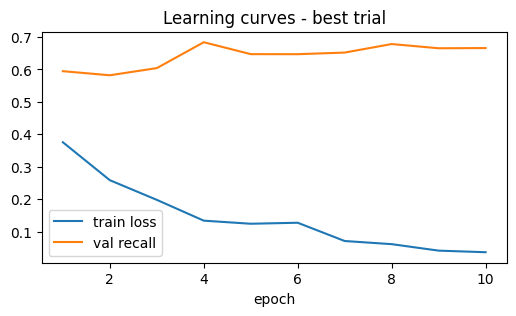

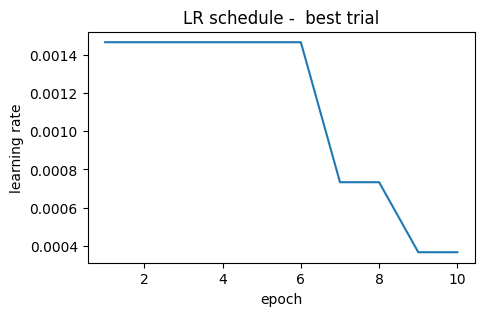

In [20]:
import matplotlib.pyplot as plt, pandas as pd

best = study.best_trial
epochs = range(1, len(best.user_attrs["lr_curve"]) + 1)

plt.figure(figsize=(6, 3))
plt.plot(epochs, best.user_attrs["train_loss_curve"], label="train loss")
plt.plot(epochs, best.user_attrs["val_recall_curve"], label="val recall")
plt.xlabel("epoch")
plt.legend()
plt.title("Learning curves - best trial")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(epochs, best.user_attrs["lr_curve"])
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("LR schedule -  best trial")
plt.show()

 ## 4. Evaluate model on test set

In [21]:
# -- Rebuild the model with params and also the test df
test_df = SUPER["test_df"]

best = study.best_trial

ckpt = best.user_attrs["ckpt"]  # "gru_ckpts/trial_17.pt"

feature_key = best.user_attrs["features"]
if feature_key == "all_numeric":
    cols = ALL_NUMERIC_COLS
else:
    cols = FEATURE_SETS[feature_key]
WIN, S = best.user_attrs["win_len"], best.user_attrs["stride"]

# rebuild windows only for test
X_te, y_te = build_windows(test_df, WIN, S, cols)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_te), torch.tensor(y_te)[:, None]),
    batch_size=256,
    shuffle=False,
)

model = GRUClassifier(
    n_feats=X_te.shape[2],
    hidden=best.params["hidden"],
    num_layers=best.params["layers"],
    dropout=best.params["drop"],
).to(DEVICE)
model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
model.eval()

GRUClassifier(
  (gru): GRU(17, 256, num_layers=2, batch_first=True, dropout=0.4)
  (head): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
)

 Evaluation

In [22]:
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())
y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

 Metrics

In [32]:
cm = confusion_matrix(y_true, y_pred)  # [[TN FP] [FN TP]]
TN, FP, FN, TP = cm.ravel()

acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN )  # sensitivity / TPR
spec = TN / (TN + FP)  # specificity / TNR
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.4f}")
print(f"Recall (TPR) : {recall :.4f}")
print(f"Specificity  : {spec :.4f}")
print(f"Precision    : {prec :.4f}")
print(f"f1-score     : {f1 :.4f}")

Confusion matrix (rows: true, cols: pred)
[[20415  6350]
 [ 4434  8388]] 

Accuracy     : 0.7276
Recall (TPR) : 0.6542
Specificity  : 0.7627
Precision    : 0.5691
f1-score     : 0.6087


In [35]:
study.best_params

{'features': 'all_numeric',
 'win_len': 120,
 'stride': 10,
 'hidden': 256,
 'layers': 2,
 'drop': 0.4,
 'lr': 0.0014661187675270907}

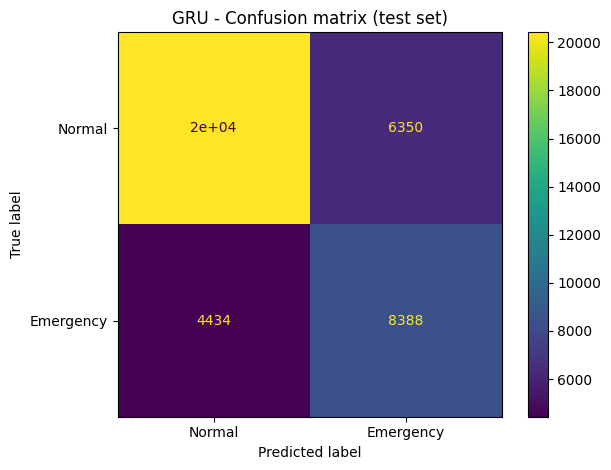

In [33]:
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Emergency"]).plot(ax=ax1)
ax1.set_title("GRU - Confusion matrix (test set)")
plt.tight_layout()
plt.show()

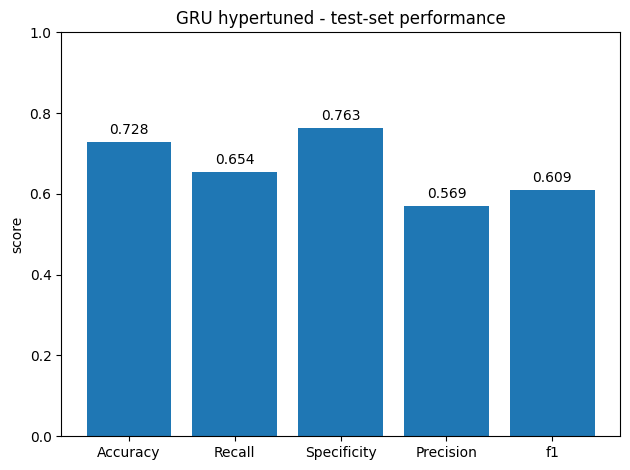

In [34]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "f1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("GRU hypertuned - test-set performance")
for idx, v in enumerate(metrics):  # annotate bars
    ax2.text(idx, v + 0.02, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()